# Notebook da dissertação de mestrado
Objetivo é:
1. Fase GPT:
    1. DADOS: Carregar dados (treino e eval) já preparados pelo notebook SIGMA2-Criar_dataset.ipynb e acrescentar ID.
    2. RAG:
        1. Criar ChromeDB integrado com modelo de embeddings da OpenAI e testar.
        2. Colocar o dataset de treino no ChromeDB para RAG. (colocar treino e eval no text-embedding-3-small, 10920 relatorios, custou US 0.56)
        3. Utilizar RAG para encontrar os melhores votos para o dataset de validação e salvar em novo arquivo.
    3. CONFERIR SEMELHANÇA DE DADOS
    4. GPT-4o
        1. Carregar dados
        2. Criar prompt
        3. Criar código para passar o GPT-4o
        4. Utilizar GPT-4o e criar lista de resultados. (4,32 mi tokens lidos e 2,41 mi tokens gerados - Custo total: R$ 347,00)
2. Fase Fine Tuning:
    1. Utilizar o notebook Fine Tuning Llama 3 Unsloth.ipynb para fazer fine tuning de um Llama 3.2. Salvar o modelo treinado.
    2. Carregar o modelo treinado neste notebook.
    3. Utilizar nos dados de validação e criar lista de resultados.
3. CheckEmbedd
    1. Criar mecanismo de verificação de similaridade com CheckEmbedd.
    2. Utilizar nas duas listas e comparar o resultado.
4. Claude
    1. **Criar código para passar o Claude**
    2. **Utilizar Claude e criar lista de resultados**
5. Llama0shot
    2. **Utilizar Llama0shot e criar lista de resultados**
6. Utilizar outro LLM para comparar os resultados ao invés do CheckEmbed.
    1. **Criar prompt para comparação dos resultados**
    2. **Criar código para comparação dos resultados**
    3. **Utilizar código para realizar comparação**

In [1]:
import torch
import os
from langchain_chroma import Chroma
from langchain.embeddings import OpenAIEmbeddings
import json
from langchain_core.documents import Document
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
pasta_base = './Datasets/novo-rel-voto-ementa/mestrado/'
eval_dados_file = pasta_base + 'eval_dados.json'
eval_mais_rag_dados_file = pasta_base + 'eval_dados_mais_rag.json'
train_dados_file = pasta_base + 'train_dados.json'
persist_directory = pasta_base + 'ChromaDB_mestrado/'
collection_name_eval = 'mestrado_rel_voto_eval'
collection_name_train = 'mestrado_rel_voto_train'

def incluir_documentos_na_base_vetorial(rag_data, vector_store):
    documents = []
    for r in rag_data:
        existing_entry = vector_store.get(ids=[str(r['idx'])])
        if len(existing_entry['ids']) == 0:
            documents.append(Document(page_content=r['relatorio'],
                          metadata={"idx" : r['idx'], "dataset": r['dataset']},
                          id = str(r['idx']))
                            )
    print('Documentos adicionados:', len(documents))
    if len(documents) > 0:
        vector_store.add_documents(documents=documents, ids=[d.id for d in documents])
    print('size:', len(vector_store.get()['documents']))

## DADOS
Dados do dataset de teste da Consuelo

### Preciso que esses dados tenham um id e posso remover campos desnecessários
Preciso executar a célula abaixo apenas uma vez.

In [2]:
with open(eval_dados_file, 'r', encoding='utf8') as json_file:
        eval_dados = json.load(json_file)
print(len(eval_dados))
with open(train_dados_file, 'r', encoding='utf8') as json_file:
        train_dados = json.load(json_file)
print(len(train_dados))
print('O formato do dataset é:', str([k for k, v in eval_dados[0].items()]))
print(eval_dados[2]['voto'])

1200
9720
O formato do dataset é: ['idx', 'voto', 'relatorio', 'dataset']
Não assiste razão à apelante.
Preliminarmente, afasto a alegação de inépcia da exordial em razão da ausência de documentos essenciais à propositura da ação, uma vez que a parte autora formulou pedido certo, determinado e inteligível, carreando aos autos, outrossim, documentos idôneos e suficientes a servir de suporte fático da pretensão deduzida em juízo.
Igualmente, não há que se falar em ilegitimidade passiva da União Federal, porquanto o próprio art. 31, do Decreto-Lei n.º 1.455/71, estabelece a responsabilidade da Secretaria da Receita Federal pelo pagamento ao depositário da tarifa de armazenagem, decorrendo a obrigação, portanto, de lei em sentido formal.
No que concerne ao pleito de reconhecimento da prescrição quinquenal prevista no art. 1º, do Decreto n.º 20.910/32, este também não deve prosperar, haja vista que a parte autora protocolou, em 18/01/2001, requerimento administrativo de ressarcimento (Proce

Células abaixo colocam o dataset no formato que preciso e salvam. Então só preciso rodar uma vez.

eval_dataset = torch.load(pasta_base + 'dataset_rel_voto_consuelo-test.pt')
print(len(eval_dataset))
print(eval_dataset[0])
eval_dados = []
idx = 0
for dado in eval_dataset:
    eval_dados.append(
        {'idx': idx,
        'voto': dado['input'],
        'relatorio': dado['output'],
        'dataset': 'eval'}
    )
    idx += 1
assert len(eval_dados) == len(eval_dataset)
with open(eval_dados_file, "w") as f:
    json.dump(eval_dados, f)

train_dataset = torch.load(pasta_base + 'dataset_rel_voto_consuelo-train.pt')
print(len(train_dataset))
print(train_dataset[0])
train_dados = []
idx = 0
for dado in train_dataset:
    train_dados.append(
        {'idx': idx,
        'voto': dado['input'],
        'relatorio': dado['output'],
        'dataset': 'train'}
    )
    idx += 1
assert len(train_dados) == len(train_dataset)
with open(train_dados_file, "w") as f:
    json.dump(train_dados, f)

## RAG

### Modelos de Embeddings da OpenAI
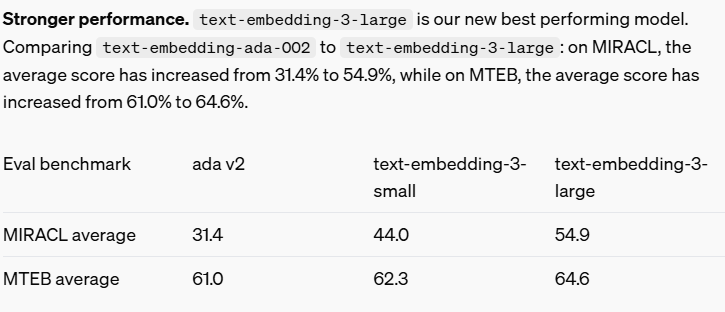
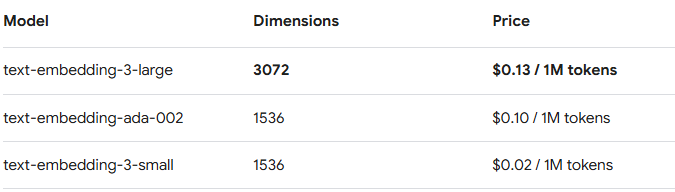

### Salvar dados no ChromeDB
Mas apenas consultar o modelo de embeddings se os dados ainda não existirem.

In [3]:
#embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key="SUA_API_KEY")
embedding_model = OpenAIEmbeddings(model = "text-embedding-3-small", openai_api_key = OPENAI_API_KEY)

# Cria ou carrega uma VectorDB
vector_store_eval = Chroma(collection_name = collection_name_eval, 
                      embedding_function = embedding_model,
                      persist_directory = persist_directory)
print('EVAL vectordb size:', len(vector_store_eval.get()['documents']))
# vector_store.persist() Desnecessário. Nas versões mais novas, o persist é automático.

vector_store_train = Chroma(collection_name = collection_name_train, 
                      embedding_function = embedding_model,
                      persist_directory = persist_directory)
print('TRAIN vectordb size:', len(vector_store_train.get()['documents']))
# vector_store.persist() Desnecessário. Nas versões mais novas, o persist é automático.
with open(eval_dados_file, 'r', encoding='utf8') as json_file:
        eval_dados = json.load(json_file)
with open(train_dados_file, 'r', encoding='utf8') as json_file:
        train_dados = json.load(json_file)

/home/fabio/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


EVAL vectordb size: 1200
TRAIN vectordb size: 9720


In [21]:
incluir_documentos_na_base_vetorial(eval_dados[0:1300], vector_store_eval)

Documentos adicionados: 1100
size: 1200


In [31]:
for a in range(29, 40):
    print('a =', a)
    incluir_documentos_na_base_vetorial(train_dados[0+a*300:300+a*300], vector_store_train)

a = 29
Documentos adicionados: 0
size: 9000
a = 30
Documentos adicionados: 300
size: 9300
a = 31
Documentos adicionados: 300
size: 9600
a = 32
Documentos adicionados: 120
size: 9720
a = 33
Documentos adicionados: 0
size: 9720
a = 34
Documentos adicionados: 0
size: 9720
a = 35
Documentos adicionados: 0
size: 9720
a = 36
Documentos adicionados: 0
size: 9720
a = 37
Documentos adicionados: 0
size: 9720
a = 38
Documentos adicionados: 0
size: 9720
a = 39
Documentos adicionados: 0
size: 9720


### Utilizar RAG

O RAG só deve procurar nos dados de treino, já que nos dados de validação há o voto correto desejado.  
No banco vetorial há apenas os relatórios. Mas para o RAG, quero encontrar o voto com o relatório mais parecido. Para isso, o retorno do RAG será um idx e eu uso esse idx para procurar o voto correto em um dicionário dict_train_dados.


In [47]:
# Criando dict_train_dados para utilização nas próximas rotinas
with open(train_dados_file, 'r', encoding='utf8') as json_file:
        train_dados = json.load(json_file)
dict_train_dados = {d['idx']: d['voto'] for d in train_dados}

# Criando rag_chain para utilização nas próximas rotinas
vector_store_train = Chroma(collection_name = collection_name_train, 
                      embedding_function = embedding_model,
                      persist_directory = persist_directory)
print('TRAIN vectordb size:', len(vector_store_train.get()['documents']))
retriever_train = vector_store_train.as_retriever()
rag_chain = retriever_train
# Usar output = rag_chain.invoke(eval_dados[0]['relatorio'])

TRAIN vectordb size: 9720


In [48]:
# Teste de saída

output = rag_chain.invoke(eval_dados[0]['relatorio'])
output

[Document(metadata={'dataset': 'train', 'idx': 4293}, page_content='Trata-se de recurso especial interposto pelo Instituto Nacional do Seguro Social contra acórdão proferido por Turma Julgadora deste Tribunal Regional Federal.   Decido.   O recurso não merece seguimento. O presente feito versa sobre a aplicabilidade do art. 1º-F da Lei 9.494/97, com redação dada pela Lei 11.960/09, em relação às condenações impostas à Fazenda Pública, independentemente de sua natureza, para fins de atualização monetária, remuneração do capital e compensação da mora, matérias submetidas à sistemática dos recursos repetitivos e/ou da repercussão geral, vinculadas aos Temas 491, 492 e 905 - STJ e ao Tema 810 - STF.   O colendo Superior Tribunal de Justiça, no julgamento proferido em recurso especial representativo da controvérsia - REsp 1.492.221, assentou que:   PROCESSUAL CIVIL. RECURSO ESPECIAL. SUBMISSÃO À REGRA PREVISTA NO ENUNCIADO ADMINISTRATIVO 02/STJ. DISCUSSÃO SOBRE A APLICAÇÃO DO ART. 1º-F DA L

In [49]:
def encontrar_votos_com_relatorios_similares(relatorio:str, rag_chain, dict_train_dados:dict):
    output = rag_chain.invoke(relatorio)  # Encontra os relatórios cadastrados no rag_chain mais parecidos com a variável relatório
    votos = []
    for documento_voto in output:
        idx = documento_voto.metadata['idx']  # Encontra o idx dos relatórios parecidos
        votos.append(dict_train_dados[idx])   # Adiciona o voto com o idx do relatório
    return votos

def completar_dataset_com_votos_do_rag(eval_dados_file:str, 
                                       eval_mais_rag_dados_file:str, 
                                       start:int,
                                       end:int,
                                       rag_chain,
                                       dict_train_dados:dict):
    if os.path.exists(eval_mais_rag_dados_file):
        with open(eval_mais_rag_dados_file, 'r', encoding='utf8') as json_file:
            eval_mais_rag_dados = json.load(json_file)
    else:            # Se o arquivo não existe, vamos criar a partir do arquivo eval_dados_file
        if os.path.exists(eval_dados_file):
            with open(eval_dados_file, 'r', encoding='utf8') as json_file:
                eval_mais_rag_dados = json.load(json_file)
        else:
            print('Erro! Nenhum dos dois arquivos existe!')
    print("Tamanho do dataset com RAG:", len(eval_mais_rag_dados))
    custo = 0
    for dado in eval_mais_rag_dados[start:end]:
        if 'votos_rag' not in dado:
            custo += 1
            dado['votos_rag'] = encontrar_votos_com_relatorios_similares(relatorio = dado['relatorio'], 
                                                                         rag_chain = rag_chain, 
                                                                         dict_train_dados = dict_train_dados)
    with open(eval_mais_rag_dados_file, "w") as f:
        json.dump(eval_mais_rag_dados, f)
    print('Arquivo salvo. Custo de embeddings - foram enviados', custo, 'relatórios para calculo dos embeddings.')

a = 0
completar_dataset_com_votos_do_rag(eval_dados_file = eval_dados_file,
                                   eval_mais_rag_dados_file = eval_mais_rag_dados_file, 
                                   start = 0 + a,
                                   end = 2000 + a,
                                   rag_chain = rag_chain,
                                   dict_train_dados = dict_train_dados)

Tamanho do dataset com RAG: 1200
Arquivo salvo. Custo de embeddings - foram enviados 1200 relatórios para calculo dos embeddings.


In [50]:
# Teste de formato
with open(eval_mais_rag_dados_file, 'r', encoding='utf8') as json_file:
        eval_mais_rag_dados = json.load(json_file)
print('O formato do dataset é:', str([k for k, v in eval_mais_rag_dados[0].items()]))
# ['votos_rag'] é uma lista de string, só com os votos mesmo.
eval_mais_rag_dados[2]

O formato do dataset é: ['idx', 'voto', 'relatorio', 'dataset', 'votos_rag']


{'idx': 2,
 'voto': "Não assiste razão à apelante.\nPreliminarmente, afasto a alegação de inépcia da exordial em razão da ausência de documentos essenciais à propositura da ação, uma vez que a parte autora formulou pedido certo, determinado e inteligível, carreando aos autos, outrossim, documentos idôneos e suficientes a servir de suporte fático da pretensão deduzida em juízo.\nIgualmente, não há que se falar em ilegitimidade passiva da União Federal, porquanto o próprio art. 31, do Decreto-Lei n.º 1.455/71, estabelece a responsabilidade da Secretaria da Receita Federal pelo pagamento ao depositário da tarifa de armazenagem, decorrendo a obrigação, portanto, de lei em sentido formal.\nNo que concerne ao pleito de reconhecimento da prescrição quinquenal prevista no art. 1º, do Decreto n.º 20.910/32, este também não deve prosperar, haja vista que a parte autora protocolou, em 18/01/2001, requerimento administrativo de ressarcimento (Processo Administrativo n.º 11128.000188/2001-65), cuja

## CONFERIR SEMELHANÇA DE DADOS
Preciso conferir se os dados em eval estão em train.  
Se forem muito parecidos, isso prejudicará a conclusão e análise de resultados.

In [45]:
for i in range(1200):
    idx = str([d['idx'] for d in eval_mais_rag_dados][i])
    result = vector_store_eval.get(ids=[idx], include=['embeddings', 'documents', 'metadatas'])
    # No ChromaDB, a função get não retorna embeddings por questão de performance. 
    # Para forçar incluir embeddings, preciso usar include=['embeddings', 'documents', 'metadatas']
    embedding_to_search = result['embeddings'][0]
    query_result = vector_store_train.similarity_search_by_vector_with_relevance_scores(
        embedding=[embedding_to_search],  # O vetor de consulta
        k=1  # Número de resultados mais próximos que deseja retornar
    )
    # _with_relevance_scores return relevance scores in the range [0, 1]. 0 is dissimilar, 1 is most similar.
    if query_result[0][1] > 0.9:
        print(query_result[0][1])

### Com o ChromaDB, é possível acessar diretamente o sqlite

In [40]:
import sqlite3

# Caminho para o banco de dados persistido
db_path = persist_directory + 'chroma.sqlite3'

# Conecte-se ao banco de dados
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Liste todas as tabelas no banco de dados
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tabelas no banco de dados:", tables)

# Verifique a estrutura da tabela que você acha que contém os vetores
cursor.execute("PRAGMA table_info(embeddings);")
columns = cursor.fetchall()
print("Estrutura da tabela:", columns)

cursor.execute("SELECT seq_id FROM embeddings")
vector_data = cursor.fetchone()
print(vector_data[0])

# Feche a conexão
conn.close()

Tabelas no banco de dados: [('migrations',), ('embeddings_queue',), ('collection_metadata',), ('segments',), ('segment_metadata',), ('tenants',), ('databases',), ('collections',), ('embeddings',), ('embedding_metadata',), ('max_seq_id',), ('embedding_fulltext_search',), ('embedding_fulltext_search_data',), ('embedding_fulltext_search_idx',), ('embedding_fulltext_search_content',), ('embedding_fulltext_search_docsize',), ('embedding_fulltext_search_config',)]
Estrutura da tabela: [(0, 'id', 'INTEGER', 0, None, 1), (1, 'segment_id', 'TEXT', 1, None, 0), (2, 'embedding_id', 'TEXT', 1, None, 0), (3, 'seq_id', 'BLOB', 1, None, 0), (4, 'created_at', 'TIMESTAMP', 1, 'CURRENT_TIMESTAMP', 0)]


## GPT-4o
Utilizar GPT-4o e criar lista de resultados.

In [2]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI

chat = ChatOpenAI(model = "gpt-4-turbo", temperature = 0)

#for dado in eval_mais_rag_dados:
# Configurar o modelo

# Criar um template de prompt
prompt = PromptTemplate(
    input_variables=["topic"],
    template="Explique sobre {topic} de maneira sucinta e clara.",
)

# Criar a cadeia
chain = LLMChain(llm=chat, prompt=prompt)

# Executar a cadeia
output = chain.run("como usar a API GPT-4-O com LangChain")
print(output)

/home/fabio/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/home/fabio/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/home/fabio/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: 9sQwwpUM************************************************************************0qHj. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [3]:
# Para acessar modelos da OpenAI via Azure
import time
import requests
import json

# Configurações da API
url = "https://diia-azureopenai.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview"
api_key = OPENAI_API_KEY

# Cabeçalhos da requisição
headers = {
    "Content-Type": "application/json",
    "api-key": api_key
}

def azure_openai_request(prompt):
# Corpo da requisição (mensagem para o modelo)
    data = {
        "messages": [
            {"role": "system", "content": "Você é um Desembargador Federal."},
            {"role": "user", "content": prompt}
        ],
            "max_tokens": 4096,  # 4096 é o máximo permitido pelo GPT4o na Azure
            "temperature": 0,   # Controle da criatividade
            "top_p": 1            # Mantenha 1 para respostas mais previsíveis
        }
    
    # Enviando a requisição
    response = requests.post(url, headers=headers, data=json.dumps(data))
    if response.status_code != 200: 
        print(f"Erro: {response.status_code}, {response.text}")
        return 'erro'
    if 'choices' not in response.json(): 
        print('Erro!!')
        print(response.json())
        return 'erro'
    return response.json()['choices'][0]['message']['content']
# Exibindo a resposta


In [4]:
with open(eval_mais_rag_dados_file, 'r', encoding='utf8') as json_file:
    eval_mais_rag_dados = json.load(json_file)
prompt_pattern = '''
# Gere um voto a partir de um RELATÓRIO e uma DECISÃO REFERÊNCIA
## Instruções para o Modelo:
Gere um VOTO fundamentado para um julgamento colegiado, a partir dos seguintes insumos:

1. RELATÓRIO: Texto que resume os fatos do processo, as alegações das partes e os fundamentos jurídicos aplicáveis.
2. DECISÃO REFERÊNCIA: Decisão anterior do mesmo Juiz ou Tribunal, utilizada como modelo para a forma de decidir e redigir.

## Requisitos para o VOTO:
- Utilize a mesma estrutura e estilo de redação da DECISÃO REFERÊNCIA.
- Mantenha os fatos e fundamentos jurídicos do RELATÓRIO, adaptando-os conforme necessário.
- Se houver citação de dispositivos legais ou precedentes, reproduza-os conforme o RELATÓRIO, ajustando ao contexto do novo caso.
- Caso a DECISÃO REFERÊNCIA contenha valores monetários ou outros detalhes específicos, substitua pelos dados do caso atual.

## Estrutura esperada:
- Análise das preliminares (se houver).
- Exame do mérito, com fundamentação jurídica baseada nos autos.
- Conclusão, com a decisão ao final.

## Entrada do Modelo:
### 1. RELATÓRIO: {RELATÓRIO}

### 2. DECISÃO REFERÊNCIA: {DECISÃO_REFERÊNCIA}

## Saída Esperada:
Um VOTO bem estruturado, claro e juridicamente fundamentado, pronto para ser utilizado como VOTO no julgamento do caso.'''
cost = 0
for i in range(1000, 1200):
    if 'gpt4o' not in eval_mais_rag_dados[i]:
        prompt = prompt_pattern.format(RELATÓRIO = eval_mais_rag_dados[i]['relatorio'], DECISÃO_REFERÊNCIA = eval_mais_rag_dados[i]['votos_rag'][0])
        #output = chain.run(prompt)
        output = azure_openai_request(prompt)
        if output != 'erro':
            eval_mais_rag_dados[i]['gpt4o'] = output
            print(i, 'succesfull:', len(output))
            cost += 1
            time.sleep(5)
            with open(eval_mais_rag_dados_file, "w") as f:
                json.dump(eval_mais_rag_dados, f)
            print('Arquivo salvo')
with open(eval_mais_rag_dados_file, "w") as f:
    json.dump(eval_mais_rag_dados, f)
print('Foram gerados', cost, 'votos')

1060 succesfull: 3905
Arquivo salvo
1061 succesfull: 15759
Arquivo salvo
1062 succesfull: 5597
Arquivo salvo
1063 succesfull: 4144
Arquivo salvo
1064 succesfull: 5873
Arquivo salvo
1065 succesfull: 15502
Arquivo salvo
1066 succesfull: 3918
Arquivo salvo
1067 succesfull: 7423
Arquivo salvo
1068 succesfull: 9777
Arquivo salvo
1069 succesfull: 6460
Arquivo salvo
1070 succesfull: 3956
Arquivo salvo
1071 succesfull: 4434
Arquivo salvo
1072 succesfull: 7969
Arquivo salvo
1073 succesfull: 3802
Arquivo salvo
1074 succesfull: 5768
Arquivo salvo
1075 succesfull: 4957
Arquivo salvo
1076 succesfull: 4363
Arquivo salvo
1077 succesfull: 3094
Arquivo salvo
1078 succesfull: 15672
Arquivo salvo
1079 succesfull: 9322
Arquivo salvo
1080 succesfull: 3674
Arquivo salvo
1081 succesfull: 4117
Arquivo salvo
1082 succesfull: 10424
Arquivo salvo
1083 succesfull: 4225
Arquivo salvo
1084 succesfull: 4806
Arquivo salvo
1085 succesfull: 3404
Arquivo salvo
1086 succesfull: 5150
Arquivo salvo
1087 succesfull: 10288
A

In [54]:
eval_mais_rag_dados[26]['relatorio']

'\nTrata-se de apelação e remessa necessária em mandado de segurança, impetrado contra o Delegado da Receita Federal em São Paulo, com o objetivo de afastar a majoração da alíquota do IRPJ, conforme disposto na Lei nº 7.988/89, sobre o resultado apurado em 31/12/1989, referente ao lucro decorrente de suas exportações no ano-base 1989.\nA liminar foi deferida mediante prévio depósito do valor do imposto questionado (fl. 13).\nO r. Juízo a quo, ao sentenciar o feito, julgou procedente o pedido, e concedeu a segurança, para o fim de reconhecer à impetrante o direito de não pagar o valor  correspondente à alíquota  de 18% sobre o lucro das exportações, referente ao Imposto de Renda relativo ao ano-base 1989, submetendo-se, assim, ao recolhimento do IR, à alíquota de 6%, consoante o decreto-lei nº 2.413/88. Sem condenação em honorários advocatícios, a teor da Súmula 512 do C. STF. Sentença sujeita ao reexame necessário.\nApelou a União Federal, pleiteando a reforma da decisão, invocando pre

# Llama

In [18]:
from llm_utils import carregar_modelo, alpaca_prompt
from unsloth import FastLanguageModel
import torch

MY_MODEL_NAME = "./fine_tuned_models/relvoto_unsloth_lora_model_llama_31_8b_4bit_pt2"
max_seq_length = 10000 #8k roda - 12k estoura
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = carregar_modelo(model_name = MY_MODEL_NAME, 
                                   max_seq_length = max_seq_length, 
                                   dtype = dtype, 
                                   load_in_4bit = load_in_4bit,
                                   criar_camada_LORA = False,
                                   inference = True)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
#pasta_base = './Datasets/novo-rel-voto-ementa/'
#dataset_file_name = 'dataset_rel_voto_consuelo.json'
#eval_dataset = torch.load(pasta_base + 'dataset/' + dataset_file_name.split('.')[0] + '-test.pt')

==((====))==  Unsloth: Fast Llama patching release 2024.8
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.988 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Modelo ./fine_tuned_models/relvoto_unsloth_lora_model_llama_31_8b_4bit_pt2 carregado.


In [67]:
with open(eval_mais_rag_dados_file, 'r', encoding='utf8') as json_file:
    eval_mais_rag_dados = json.load(json_file)
instruction = 'Você é um desembargador do Tribunal Regional Federal. Abaixo há um relatório com os fatos do processo. \nEscreva um voto que decida a questão exposta no relatório. O voto deve ter uma fundamentação jurídica e uma decisão ao final.'
cost = 0
for i, dado in enumerate(eval_mais_rag_dados):
    if 'llama' not in dado:
        prompt = tokenizer([alpaca_prompt.format(instruction, dado['relatorio'], '')], return_tensors = "pt").to("cuda")
        generated_output = model.generate(**prompt, max_new_tokens = 10000, use_cache = True)
        generated_output = tokenizer.batch_decode(generated_output)[0]
        generated_output = generated_output.replace('<|eot_id|>', '').replace('<|begin_of_text|>', '')
        eval_mais_rag_dados[i]['llama'] = generated_output
        print(i)
        cost += 1
        if cost % 5 == 0:
            with open(eval_mais_rag_dados_file, "w") as f:
                json.dump(eval_mais_rag_dados, f)
            print('Arquivo salvo')
with open(eval_mais_rag_dados_file, "w") as f:
    json.dump(eval_mais_rag_dados, f)

In [58]:
print(eval_mais_rag_dados[0]['llama'])

Abaixo está uma instrução que descreve uma tarefa, juntamente com uma entrada que fornece mais contexto. Escreva uma resposta que complete adequadamente o pedido.

### Instrução:
Você é um desembargador do Tribunal Regional Federal. Abaixo há um relatório com os fatos do processo. 
Escreva um voto que decida a questão exposta no relatório. O voto deve ter uma fundamentação jurídica e uma decisão ao final.

### Entrada:
Trata-se de recurso especial interposto pelo INSS em face de acórdão proferido por órgão fracionário deste Tribunal Regional Federal.DECIDO.A presente impugnação não pode ser admitida.O C. Superior Tribunal de Justiça, no julgamento do Resp nº 1.831.371/SP, julgado sob o rito dos recursos repetitivos, publicado em 02/03/2021, assentou que "é admissível o reconhecimento da especialidade da atividade de Vigilante, com ou sem o uso de arma de fogo, em data posterior à Lei 9.032/1995 e ao Decreto 2.172/1997, desde que haja a comprovação da efetiva nocividade da atividade, po

In [62]:
for i, dado in enumerate(eval_mais_rag_dados):
    if '### Resposta:' not in dado['llama']:
        print(i)
        raise error

In [44]:
generated_output

'Abaixo está uma instrução que descreve uma tarefa, juntamente com uma entrada que fornece mais contexto. Escreva uma resposta que complete adequadamente o pedido.\n\n### Instrução:\nVocê é um desembargador do Tribunal Regional Federal. Abaixo há um relatório com os fatos do processo. \nEscreva um voto que decida a questão exposta no relatório. O voto deve ter uma fundamentação jurídica e uma decisão ao final.\n\n### Entrada:\n\nTrata-se de agravo legal interposto contra a decisão monocrática que julgou extinto o processo, sem resolução de mérito (art. 267, VI, CPC), diante da carência da ação e negou seguimento às apelações, porquanto prejudicadas (CPC, art. 557, caput), em sede de medida cautelar de exibição de documentos ajuizada pela União Federal em face do Banco Sudameris Brasil S/A e Márcio Mesquita Serva, objetivando a quebra do sigilo bancário do correntista, com vistas a apurar indícios de infração à legislação tributária no tocante ao IRPF, em razão de omissão de receita tri

In [37]:
generated_output = tokenizer.batch_decode(generated_output)[0]

In [39]:
generated_output = generated_output[0]